In [2]:
import torch
import numpy as np
from RL.simulation_prolile import reaction_condition
from RL.environment import environment,state_info
from RL.policy_net import Policy_gradient
from desity_estimator import encode_structure,model_cvd_series,decode_structure
from util import load_model

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load Probablity density estimate  $P(z_{t+1}|z_{1:t},x_{1:t})$ of MD-CVD dynamics trained using offline MD data using neural autoregressive desity estimator  

In [3]:
#load MD surrogate model
batch = 32
natoms = 288.0
model_name = 'MD_MoS2'
net_parameters = {'input_dim':7,'output_dim':72,'hidden_dim':128,'batch_size':batch}
encoder=encode_structure(net_parameters)
decoder = decode_structure(net_parameters)
md_model = model_cvd_series(encoder,decoder,net_parameters,loss_type='mle',sigma=0.01)
#load moldel parameters
load_model(md_model,model_name)
print("sigma_type:",md_model.sigma_type,"loss_type:",md_model.loss_type,"sigma:",md_model.sigma)

sigma_type: const loss_type: mle sigma: 0.01


### Create an RL-Agent 

In [4]:
#create RL agrent 
action_scale = torch.tensor([50.0,1.0,1.0,1.0]).unsqueeze(0)
sim_param_std = torch.tensor([5.0,5.0,5.0,5.0],dtype=torch.float32).unsqueeze(0)
rl_agent = Policy_gradient(net_parameters['hidden_dim'],sim_param_std,learning_rate=0.001,gamma=0.99)
sim_condition = reaction_condition()
env = environment(md_model,sim_condition)

In [5]:
C_ = np.expand_dims(env.generate_start_condition(batch=batch),axis=1)
Cn_ = torch.tensor(C_,dtype=torch.float32)
Y0_ = torch.zeros((Cn_.size()[0],3),dtype=torch.float32)
Y0_[:,2] = 1.0
next_C_mu,C_v,hx = env.get_states_representation(Cn_,Y0_)
print(next_C_mu.size(),hx.size())

torch.Size([32, 1, 3]) torch.Size([32, 1, 128])


### Train the RL agent 

In [49]:
rl_agent.model.train()
r_scale = 5.0
threshold = 100.0/r_scale
upper_bound = 140/r_scale
#reward_trj = []
for i_episode in range(7000):
    tot_reward = []
    tot_log_prob = []
    reward_sum = []
    state_value_trj = []
    mu_gas = []
    C_ = np.expand_dims(env.generate_start_condition(batch=batch),axis=1)
    Cn_ = torch.tensor(C_,dtype=torch.float32)
    Y0_ = torch.zeros((Cn_.size()[0],3),dtype=torch.float32)
    Y0_[:,2] = 1.0
    next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
    #rl trajectorry
    for j in range(19):
        cur_state = hx[:,j,:]
        action,log_prob,mu,state_value = rl_agent.select_action(cur_state)
        cmean = Cn_[:,j,:] + action * action_scale
        #clip condtion within simulation range
        for k in range(cmean.size()[0]):
            if cmean[k,0] < 750.0:
                cmean[k,0] = 750.0
            if cmean[k,0] > 3750.0:
                cmean[k,0] = 3750.0
            if cmean[k,1] < 20.0:
                cmean[k,1] = 20.0
            if cmean[k,1] > 200.0:
                cmean[k,1] = 190.0
            if cmean[k,2] < 20.0:
                cmean[k,2] = 20.0
            if cmean[k,2] > 200.0:
                cmean[k,2] = 190.0
            if cmean[k,3] < 20.0:
                cmean[k,3] = 20.0
            if cmean[k,3] > 200.0:
                cmean[k,3] = 190.0
        Cn_ = torch.cat((Cn_,cmean.unsqueeze(1)),dim=1)
        next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
        with torch.no_grad():
            Ht_conc = torch.round(natoms*next_Y_mu[:,j,0])
            reward = Ht_conc/r_scale
            reward[reward < threshold] = 0.0
            reward[reward > upper_bound] = 0.0
        tot_reward.append(reward)
        reward_sum.append(reward.numpy())
        tot_log_prob.append(log_prob)
        state_value_trj.append(state_value)
        mu_gas.append(mu)
        #print(Cn_.size(),next_Y_mu.size(),reward.size())
    mean_2H = Ht_conc.mean()
    max_2H = torch.max(Ht_conc)
    loss,p_loss,v_loss = rl_agent.update_parameters(tot_reward, tot_log_prob,mu_gas,state_value_trj,batch=batch)
    reward_sum = np.asarray(reward_sum).transpose()
    expected_reward = reward_sum.sum(-1).mean()
    reward_trj.append(expected_reward)
    if i_episode % 5 == 0:
        print("episode {0:6d} reward {1:6.3f} loss {2:6.3f} mean_2H {3:6.1f} max_2H {4:6.1f} p_loss {5:6.3f} v_loss {6:6.3f}".
             format(i_episode,expected_reward,loss.item(),mean_2H.item(),max_2H.item(),p_loss.item(),v_loss.item()))
print("done")

episode      0 reward 161.394 loss 4097.869 mean_2H  127.7 max_2H  205.0 p_loss 2910.772 v_loss 1187.096
episode      5 reward 141.500 loss 1895.029 mean_2H  115.7 max_2H  200.0 p_loss 724.344 v_loss 1170.686
episode     10 reward 153.062 loss 2807.190 mean_2H  132.0 max_2H  220.0 p_loss 1665.791 v_loss 1141.399
episode     15 reward 160.844 loss 4034.663 mean_2H  109.8 max_2H  184.0 p_loss 2821.294 v_loss 1213.369
episode     20 reward 147.044 loss 1952.581 mean_2H  115.7 max_2H  198.0 p_loss 780.783 v_loss 1171.798
episode     25 reward 187.819 loss 7205.553 mean_2H  111.2 max_2H  189.0 p_loss 5989.409 v_loss 1216.143
episode     30 reward 162.100 loss 4484.036 mean_2H  111.9 max_2H  177.0 p_loss 3421.640 v_loss 1062.396
episode     35 reward 150.087 loss 3234.477 mean_2H  107.0 max_2H  201.0 p_loss 2089.089 v_loss 1145.388
episode     40 reward 161.444 loss 4263.053 mean_2H  118.0 max_2H  224.0 p_loss 2955.752 v_loss 1307.301
episode     45 reward 171.856 loss 6672.448 mean_2H  113.

episode    395 reward 179.113 loss 6988.076 mean_2H  110.3 max_2H  183.0 p_loss 5617.302 v_loss 1370.774
episode    400 reward 168.981 loss 5561.083 mean_2H  117.6 max_2H  199.0 p_loss 4344.497 v_loss 1216.586
episode    405 reward 168.537 loss 5256.059 mean_2H  115.8 max_2H  152.0 p_loss 4038.916 v_loss 1217.143
episode    410 reward 170.500 loss 6207.256 mean_2H  104.2 max_2H  138.0 p_loss 4953.553 v_loss 1253.703
episode    415 reward 168.575 loss 4039.773 mean_2H  118.8 max_2H  209.0 p_loss 2849.630 v_loss 1190.142
episode    420 reward 139.525 loss 356.559 mean_2H  121.9 max_2H  206.0 p_loss -919.551 v_loss 1276.110
episode    425 reward 163.688 loss 2767.988 mean_2H  108.0 max_2H  182.0 p_loss 1671.254 v_loss 1096.734
episode    430 reward 128.394 loss -623.352 mean_2H  102.1 max_2H  146.0 p_loss -1698.214 v_loss 1074.861
episode    435 reward 141.512 loss 1463.002 mean_2H  109.5 max_2H  162.0 p_loss 356.098 v_loss 1106.905
episode    440 reward 159.319 loss 3784.317 mean_2H  118

episode    790 reward 178.087 loss 5490.636 mean_2H  109.5 max_2H  134.0 p_loss 4371.082 v_loss 1119.554
episode    795 reward 132.194 loss -842.730 mean_2H  120.1 max_2H  181.0 p_loss -1978.040 v_loss 1135.310
episode    800 reward 166.175 loss 2943.959 mean_2H  116.7 max_2H  225.0 p_loss 1719.772 v_loss 1224.187
episode    805 reward 133.075 loss 256.566 mean_2H  114.6 max_2H  212.0 p_loss -963.759 v_loss 1220.325
episode    810 reward 115.400 loss -1586.033 mean_2H  101.8 max_2H  175.0 p_loss -2809.906 v_loss 1223.874
episode    815 reward 137.587 loss 854.937 mean_2H  111.6 max_2H  232.0 p_loss -362.594 v_loss 1217.531
episode    820 reward 138.325 loss 2141.301 mean_2H  116.0 max_2H  207.0 p_loss 905.945 v_loss 1235.356
episode    825 reward 154.094 loss 4365.843 mean_2H  115.7 max_2H  194.0 p_loss 3062.690 v_loss 1303.153
episode    830 reward 141.663 loss 2900.916 mean_2H  123.4 max_2H  201.0 p_loss 1869.154 v_loss 1031.763
episode    835 reward 177.150 loss 6402.571 mean_2H  11

episode   1185 reward 182.956 loss 5025.937 mean_2H  125.6 max_2H  185.0 p_loss 3866.979 v_loss 1158.958
episode   1190 reward 184.431 loss 6991.770 mean_2H  117.1 max_2H  152.0 p_loss 5732.731 v_loss 1259.038
episode   1195 reward 202.094 loss 7633.476 mean_2H  118.7 max_2H  166.0 p_loss 6247.023 v_loss 1386.452
episode   1200 reward 173.931 loss 3767.478 mean_2H  118.3 max_2H  180.0 p_loss 2645.486 v_loss 1121.992
episode   1205 reward 150.700 loss 42.476 mean_2H  116.2 max_2H  198.0 p_loss -1146.082 v_loss 1188.557
episode   1210 reward 175.238 loss 4091.207 mean_2H  120.2 max_2H  242.0 p_loss 2777.079 v_loss 1314.127
episode   1215 reward 160.694 loss 2468.409 mean_2H  111.1 max_2H  182.0 p_loss 1241.966 v_loss 1226.443
episode   1220 reward 165.838 loss 3868.547 mean_2H  109.4 max_2H  188.0 p_loss 2611.193 v_loss 1257.354
episode   1225 reward 200.113 loss 6576.871 mean_2H  116.7 max_2H  155.0 p_loss 5426.223 v_loss 1150.648
episode   1230 reward 145.062 loss 1224.592 mean_2H  108

episode   1580 reward 184.100 loss 4418.234 mean_2H  114.9 max_2H  165.0 p_loss 3269.097 v_loss 1149.137
episode   1585 reward 163.025 loss 1439.235 mean_2H  108.1 max_2H  173.0 p_loss 412.741 v_loss 1026.493
episode   1590 reward 174.969 loss 4849.946 mean_2H  113.0 max_2H  170.0 p_loss 3688.838 v_loss 1161.108
episode   1595 reward 162.719 loss 4237.630 mean_2H  111.6 max_2H  158.0 p_loss 3134.881 v_loss 1102.749
episode   1600 reward 182.319 loss 3902.090 mean_2H  119.4 max_2H  159.0 p_loss 2786.120 v_loss 1115.970
episode   1605 reward 144.469 loss 488.476 mean_2H  105.8 max_2H  170.0 p_loss -764.237 v_loss 1252.713
episode   1610 reward 186.262 loss 4664.080 mean_2H  119.3 max_2H  181.0 p_loss 3362.466 v_loss 1301.614
episode   1615 reward 156.787 loss 715.686 mean_2H  111.1 max_2H  182.0 p_loss -460.139 v_loss 1175.825
episode   1620 reward 172.600 loss 2465.243 mean_2H  116.0 max_2H  215.0 p_loss 1330.158 v_loss 1135.085
episode   1625 reward 159.531 loss 1447.301 mean_2H  113.9

episode   1975 reward 151.800 loss 3042.382 mean_2H  115.8 max_2H  160.0 p_loss 1920.567 v_loss 1121.815
episode   1980 reward 186.600 loss 5680.142 mean_2H  114.4 max_2H  179.0 p_loss 4472.576 v_loss 1207.566
episode   1985 reward 180.812 loss 5679.007 mean_2H  123.3 max_2H  236.0 p_loss 4416.761 v_loss 1262.246
episode   1990 reward 177.962 loss 4873.099 mean_2H  125.8 max_2H  185.0 p_loss 3705.427 v_loss 1167.671
episode   1995 reward 148.062 loss -33.277 mean_2H  106.7 max_2H  153.0 p_loss -1309.183 v_loss 1275.906
episode   2000 reward 175.462 loss 3330.306 mean_2H  115.8 max_2H  180.0 p_loss 2103.320 v_loss 1226.986
episode   2005 reward 173.075 loss 4276.604 mean_2H  124.9 max_2H  223.0 p_loss 2918.748 v_loss 1357.856
episode   2010 reward 169.206 loss 3353.604 mean_2H  110.5 max_2H  151.0 p_loss 2113.344 v_loss 1240.259
episode   2015 reward 171.525 loss 5783.817 mean_2H  109.8 max_2H  142.0 p_loss 4345.718 v_loss 1438.100
episode   2020 reward 173.319 loss 4394.985 mean_2H  11

episode   2370 reward 211.319 loss 8139.839 mean_2H  118.0 max_2H  182.0 p_loss 6963.227 v_loss 1176.612
episode   2375 reward 165.688 loss 2918.144 mean_2H  129.1 max_2H  191.0 p_loss 1726.653 v_loss 1191.491
episode   2380 reward 173.475 loss 2976.260 mean_2H  118.2 max_2H  220.0 p_loss 1715.074 v_loss 1261.186
episode   2385 reward 166.144 loss 1674.835 mean_2H  120.3 max_2H  166.0 p_loss 411.698 v_loss 1263.137
episode   2390 reward 182.137 loss 3609.752 mean_2H  125.4 max_2H  173.0 p_loss 2358.054 v_loss 1251.698
episode   2395 reward 165.369 loss 1585.392 mean_2H  115.2 max_2H  194.0 p_loss 400.866 v_loss 1184.526
episode   2400 reward 160.431 loss 2936.724 mean_2H  121.9 max_2H  181.0 p_loss 1664.237 v_loss 1272.486
episode   2405 reward 203.238 loss 8905.569 mean_2H  123.9 max_2H  209.0 p_loss 7610.441 v_loss 1295.128
episode   2410 reward 168.944 loss 3189.019 mean_2H  125.1 max_2H  211.0 p_loss 1861.908 v_loss 1327.110
episode   2415 reward 171.156 loss 3768.022 mean_2H  116.

episode   2765 reward 166.575 loss 2392.740 mean_2H  108.8 max_2H  183.0 p_loss 1400.997 v_loss 991.744
episode   2770 reward 175.856 loss 5007.596 mean_2H  115.3 max_2H  155.0 p_loss 3859.811 v_loss 1147.785
episode   2775 reward 188.400 loss 5398.956 mean_2H  121.9 max_2H  177.0 p_loss 4241.805 v_loss 1157.151
episode   2780 reward 172.369 loss 3713.479 mean_2H  118.8 max_2H  186.0 p_loss 2518.053 v_loss 1195.426
episode   2785 reward 205.856 loss 7795.139 mean_2H  119.1 max_2H  167.0 p_loss 6474.132 v_loss 1321.006
episode   2790 reward 190.663 loss 5717.112 mean_2H  118.8 max_2H  162.0 p_loss 4602.786 v_loss 1114.326
episode   2795 reward 157.562 loss 694.775 mean_2H  126.3 max_2H  188.0 p_loss -426.415 v_loss 1121.190
episode   2800 reward 175.450 loss 4400.111 mean_2H  118.6 max_2H  185.0 p_loss 3192.773 v_loss 1207.338
episode   2805 reward 199.081 loss 6823.970 mean_2H  114.8 max_2H  158.0 p_loss 5428.492 v_loss 1395.479
episode   2810 reward 162.650 loss 1248.873 mean_2H  124.

episode   3160 reward 164.119 loss 1158.919 mean_2H  118.2 max_2H  176.0 p_loss -98.997 v_loss 1257.916
episode   3165 reward 196.581 loss 5856.502 mean_2H  128.6 max_2H  188.0 p_loss 4454.615 v_loss 1401.887
episode   3170 reward 192.231 loss 5152.999 mean_2H  119.7 max_2H  193.0 p_loss 3854.027 v_loss 1298.973
episode   3175 reward 199.606 loss 5446.309 mean_2H  115.5 max_2H  160.0 p_loss 4261.234 v_loss 1185.075
episode   3180 reward 182.769 loss 3647.784 mean_2H  128.8 max_2H  209.0 p_loss 2474.976 v_loss 1172.807
episode   3185 reward 169.181 loss 1296.084 mean_2H  116.0 max_2H  153.0 p_loss 196.411 v_loss 1099.673
episode   3190 reward 163.969 loss 2116.082 mean_2H  119.6 max_2H  174.0 p_loss 1020.575 v_loss 1095.506
episode   3195 reward 160.506 loss 1118.235 mean_2H  102.5 max_2H  148.0 p_loss 131.896 v_loss 986.339
episode   3200 reward 140.869 loss -171.169 mean_2H   96.8 max_2H  141.0 p_loss -1262.324 v_loss 1091.155
episode   3205 reward 160.587 loss 3596.875 mean_2H  110.7

episode   3555 reward 185.519 loss 3538.239 mean_2H  115.8 max_2H  156.0 p_loss 2372.660 v_loss 1165.579
episode   3560 reward 171.387 loss 1984.060 mean_2H  114.9 max_2H  178.0 p_loss 933.905 v_loss 1050.155
episode   3565 reward 178.788 loss 2698.877 mean_2H  121.2 max_2H  168.0 p_loss 1579.478 v_loss 1119.400
episode   3570 reward 187.875 loss 4296.643 mean_2H  117.6 max_2H  177.0 p_loss 3010.044 v_loss 1286.599
episode   3575 reward 170.025 loss 1461.125 mean_2H  117.1 max_2H  187.0 p_loss 473.007 v_loss 988.118
episode   3580 reward 178.450 loss 1896.348 mean_2H  119.8 max_2H  176.0 p_loss 831.450 v_loss 1064.898
episode   3585 reward 194.844 loss 3888.098 mean_2H  114.7 max_2H  182.0 p_loss 2788.009 v_loss 1100.089
episode   3590 reward 167.106 loss 1538.405 mean_2H  113.7 max_2H  162.0 p_loss 361.980 v_loss 1176.425
episode   3595 reward 191.225 loss 4423.722 mean_2H  111.2 max_2H  149.0 p_loss 3305.165 v_loss 1118.557
episode   3600 reward 171.081 loss 1836.139 mean_2H  116.4 m

episode   3950 reward 190.113 loss 4632.318 mean_2H  113.9 max_2H  168.0 p_loss 3216.382 v_loss 1415.936
episode   3955 reward 196.275 loss 6153.590 mean_2H  114.2 max_2H  182.0 p_loss 4771.365 v_loss 1382.225
episode   3960 reward 164.400 loss 1239.372 mean_2H  115.8 max_2H  198.0 p_loss 18.986 v_loss 1220.386
episode   3965 reward 165.681 loss 2197.596 mean_2H  108.8 max_2H  181.0 p_loss 850.974 v_loss 1346.621
episode   3970 reward 155.613 loss 433.075 mean_2H  114.2 max_2H  157.0 p_loss -837.509 v_loss 1270.584
episode   3975 reward 188.881 loss 4249.190 mean_2H  115.5 max_2H  150.0 p_loss 2923.031 v_loss 1326.159
episode   3980 reward 192.863 loss 4318.026 mean_2H  109.4 max_2H  133.0 p_loss 3054.538 v_loss 1263.489
episode   3985 reward 150.738 loss -1197.558 mean_2H  114.3 max_2H  182.0 p_loss -2587.851 v_loss 1390.293
episode   3990 reward 219.525 loss 6507.101 mean_2H  111.7 max_2H  171.0 p_loss 5148.385 v_loss 1358.715
episode   3995 reward 174.462 loss 2555.149 mean_2H  110.

episode   4345 reward 181.300 loss 3256.089 mean_2H  109.9 max_2H  149.0 p_loss 1938.122 v_loss 1317.967
episode   4350 reward 206.706 loss 5738.062 mean_2H  113.8 max_2H  170.0 p_loss 4452.103 v_loss 1285.958
episode   4355 reward 158.638 loss -370.479 mean_2H  112.9 max_2H  158.0 p_loss -1533.661 v_loss 1163.181
episode   4360 reward 188.000 loss 3041.737 mean_2H  106.8 max_2H  147.0 p_loss 1748.565 v_loss 1293.172
episode   4365 reward 195.944 loss 3740.217 mean_2H  112.1 max_2H  198.0 p_loss 2421.298 v_loss 1318.920
episode   4370 reward 189.837 loss 3136.040 mean_2H  116.8 max_2H  174.0 p_loss 1903.120 v_loss 1232.920
episode   4375 reward 198.862 loss 5068.328 mean_2H  116.8 max_2H  182.0 p_loss 3831.907 v_loss 1236.421
episode   4380 reward 187.181 loss 2941.484 mean_2H  114.8 max_2H  164.0 p_loss 1676.501 v_loss 1264.983
episode   4385 reward 184.363 loss 2861.684 mean_2H  117.8 max_2H  185.0 p_loss 1594.331 v_loss 1267.353
episode   4390 reward 182.606 loss 3803.219 mean_2H  1

episode   4740 reward 191.319 loss 1398.710 mean_2H  110.6 max_2H  161.0 p_loss 200.356 v_loss 1198.354
episode   4745 reward 187.913 loss 2391.185 mean_2H  120.1 max_2H  190.0 p_loss 1126.064 v_loss 1265.121
episode   4750 reward 174.413 loss 1605.863 mean_2H  115.8 max_2H  178.0 p_loss 458.542 v_loss 1147.322
episode   4755 reward 172.344 loss 2084.339 mean_2H  110.2 max_2H  158.0 p_loss 856.868 v_loss 1227.470
episode   4760 reward 195.212 loss 5245.464 mean_2H  116.6 max_2H  176.0 p_loss 4035.913 v_loss 1209.551
episode   4765 reward 169.188 loss 1547.576 mean_2H  112.7 max_2H  173.0 p_loss 272.843 v_loss 1274.734
episode   4770 reward 185.225 loss 3189.063 mean_2H  114.4 max_2H  172.0 p_loss 1898.035 v_loss 1291.028
episode   4775 reward 172.869 loss 2141.997 mean_2H  120.5 max_2H  190.0 p_loss 964.327 v_loss 1177.670
episode   4780 reward 193.050 loss 5352.207 mean_2H  117.1 max_2H  153.0 p_loss 4110.499 v_loss 1241.708
episode   4785 reward 192.456 loss 5010.669 mean_2H  111.3 m

episode   5135 reward 192.150 loss 3032.444 mean_2H  121.3 max_2H  187.0 p_loss 1912.476 v_loss 1119.968
episode   5140 reward 192.575 loss 2572.872 mean_2H  116.5 max_2H  163.0 p_loss 1395.600 v_loss 1177.272
episode   5145 reward 183.669 loss 1804.273 mean_2H  117.2 max_2H  189.0 p_loss 732.530 v_loss 1071.743
episode   5150 reward 131.475 loss -3915.373 mean_2H  111.1 max_2H  163.0 p_loss -5205.291 v_loss 1289.917
episode   5155 reward 154.594 loss 68.546 mean_2H  107.5 max_2H  151.0 p_loss -969.089 v_loss 1037.636
episode   5160 reward 160.875 loss 1842.649 mean_2H  104.9 max_2H  148.0 p_loss 776.145 v_loss 1066.505
episode   5165 reward 170.094 loss 3459.342 mean_2H  107.6 max_2H  164.0 p_loss 2239.609 v_loss 1219.734
episode   5170 reward 185.950 loss 6510.098 mean_2H  120.9 max_2H  192.0 p_loss 5310.662 v_loss 1199.437
episode   5175 reward 187.350 loss 6264.507 mean_2H  118.2 max_2H  201.0 p_loss 5051.435 v_loss 1213.072
episode   5180 reward 201.981 loss 6581.092 mean_2H  124.

episode   5530 reward 202.350 loss 4074.752 mean_2H  110.1 max_2H  169.0 p_loss 2682.916 v_loss 1391.835
episode   5535 reward 180.513 loss 2102.015 mean_2H  115.2 max_2H  194.0 p_loss 841.092 v_loss 1260.923
episode   5540 reward 193.106 loss 2466.032 mean_2H  114.4 max_2H  154.0 p_loss 1360.306 v_loss 1105.727
episode   5545 reward 199.438 loss 3709.875 mean_2H  111.2 max_2H  142.0 p_loss 2569.873 v_loss 1140.001
episode   5550 reward 204.831 loss 4656.640 mean_2H  116.9 max_2H  148.0 p_loss 3487.280 v_loss 1169.360
episode   5555 reward 174.675 loss 643.236 mean_2H  121.8 max_2H  171.0 p_loss -567.299 v_loss 1210.535
episode   5560 reward 181.869 loss 2326.521 mean_2H  115.4 max_2H  207.0 p_loss 1275.334 v_loss 1051.187
episode   5565 reward 165.962 loss 98.745 mean_2H  110.4 max_2H  168.0 p_loss -931.298 v_loss 1030.043
episode   5570 reward 172.800 loss 1111.170 mean_2H  111.5 max_2H  151.0 p_loss -115.073 v_loss 1226.244
episode   5575 reward 168.713 loss 1332.191 mean_2H  115.2 

episode   5925 reward 203.494 loss 4628.996 mean_2H  111.3 max_2H  152.0 p_loss 3412.423 v_loss 1216.573
episode   5930 reward 120.569 loss -4142.479 mean_2H  103.5 max_2H  153.0 p_loss -5487.279 v_loss 1344.800
episode   5935 reward 173.919 loss 1019.566 mean_2H  118.6 max_2H  177.0 p_loss -213.246 v_loss 1232.812
episode   5940 reward 165.881 loss 877.035 mean_2H  117.7 max_2H  171.0 p_loss -376.583 v_loss 1253.617
episode   5945 reward 180.000 loss 2777.541 mean_2H  120.7 max_2H  196.0 p_loss 1449.985 v_loss 1327.555
episode   5950 reward 205.031 loss 6036.328 mean_2H  125.6 max_2H  242.0 p_loss 4845.664 v_loss 1190.665
episode   5955 reward 219.794 loss 5961.241 mean_2H  116.6 max_2H  192.0 p_loss 4714.314 v_loss 1246.926
episode   5960 reward 190.131 loss 2530.035 mean_2H  111.0 max_2H  174.0 p_loss 1297.058 v_loss 1232.978
episode   5965 reward 184.331 loss 545.729 mean_2H  109.2 max_2H  150.0 p_loss -524.883 v_loss 1070.612
episode   5970 reward 184.000 loss 948.704 mean_2H  113

episode   6320 reward 190.062 loss 4331.833 mean_2H  105.3 max_2H  166.0 p_loss 3127.685 v_loss 1204.148
episode   6325 reward 171.287 loss 1195.828 mean_2H  116.9 max_2H  191.0 p_loss -111.269 v_loss 1307.097
episode   6330 reward 212.738 loss 4365.417 mean_2H  115.8 max_2H  163.0 p_loss 3139.031 v_loss 1226.387
episode   6335 reward 154.950 loss -1738.958 mean_2H  110.9 max_2H  214.0 p_loss -3041.781 v_loss 1302.823
episode   6340 reward 177.062 loss 1143.947 mean_2H  108.8 max_2H  141.0 p_loss 46.229 v_loss 1097.718
episode   6345 reward 167.806 loss -260.906 mean_2H  121.7 max_2H  209.0 p_loss -1477.349 v_loss 1216.443
episode   6350 reward 180.912 loss 3582.737 mean_2H  113.9 max_2H  176.0 p_loss 2225.511 v_loss 1357.226
episode   6355 reward 195.300 loss 5370.483 mean_2H  112.6 max_2H  179.0 p_loss 4147.017 v_loss 1223.466
episode   6360 reward 208.125 loss 6589.688 mean_2H  114.5 max_2H  179.0 p_loss 5280.007 v_loss 1309.680
episode   6365 reward 186.219 loss 2937.258 mean_2H  1

episode   6715 reward 199.350 loss 2945.640 mean_2H  115.8 max_2H  168.0 p_loss 1714.071 v_loss 1231.569
episode   6720 reward 189.706 loss 1059.712 mean_2H  116.6 max_2H  178.0 p_loss -74.663 v_loss 1134.375
episode   6725 reward 192.225 loss 1196.019 mean_2H  108.4 max_2H  153.0 p_loss -96.265 v_loss 1292.283
episode   6730 reward 194.862 loss 3465.588 mean_2H  114.2 max_2H  153.0 p_loss 2230.859 v_loss 1234.729
episode   6735 reward 201.944 loss 2809.081 mean_2H  113.2 max_2H  171.0 p_loss 1688.623 v_loss 1120.458
episode   6740 reward 195.250 loss 3136.096 mean_2H  115.9 max_2H  200.0 p_loss 1923.394 v_loss 1212.702
episode   6745 reward 201.375 loss 4280.654 mean_2H  116.7 max_2H  182.0 p_loss 2953.582 v_loss 1327.072
episode   6750 reward 215.325 loss 5150.468 mean_2H  118.0 max_2H  155.0 p_loss 3879.449 v_loss 1271.018
episode   6755 reward 165.138 loss -736.645 mean_2H  108.2 max_2H  164.0 p_loss -1936.460 v_loss 1199.816
episode   6760 reward 187.650 loss 2158.774 mean_2H  116

### Visulaize the  rewards as a function of training episode of RL

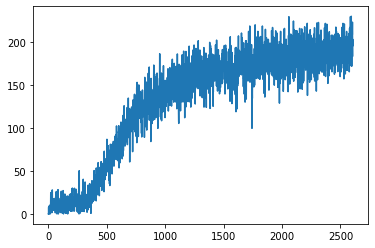

In [50]:
plt.plot(reward_trj[::5])
plt.show()

### Generate new trajectory for evalulation using the trained RL Agent 

In [867]:
#sample new trajectory
rl_agent.model.eval()
C_ = np.expand_dims(env.generate_start_condition(batch=batch),axis=1)
Cn_ = torch.tensor(C_,dtype=torch.float32)
Y0_ = torch.zeros((Cn_.size()[0],3),dtype=torch.float32)
Y0_[:,2] = 1.0
next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
for j in range(19):
    cur_state = hx[:,j,:]
    action,log_prob,mu,state_value = rl_agent.select_action(cur_state)
    cmean = Cn_[:,j,:] + action * action_scale
    #clip condtion within simulation range
    for k in range(cmean.size()[0]):
        if cmean[k,0] < 750.0:
            cmean[k,0] = 750.0
        if cmean[k,0] > 3750.0:
            cmean[k,0] = 3750.0
        if cmean[k,1] < 20.0:
            cmean[k,1] = 20.0
        if cmean[k,1] > 200.0:
            cmean[k,1] = 190.0
        if cmean[k,2] < 20.0:
            cmean[k,2] = 20.0
        if cmean[k,2] > 190.0:
            cmean[k,2] = 200.0
        if cmean[k,3] < 20.0:
            cmean[k,3] = 20.0
        if cmean[k,3] > 200.0:
            cmean[k,3] = 190.0
    Cn_ = torch.cat((Cn_,cmean.unsqueeze(1)),dim=1)
    next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
    Ht_conc = torch.round(natoms*next_Y_mu[:,j,0])
print("done:",Ht_conc)

done: tensor([ 98., 152., 120., 116., 117., 101., 105., 141., 115., 103., 118., 126.,
        119., 120.,  71., 123., 113.,  99., 123., 125., 106., 120., 104., 148.,
        124., 117., 117., 145., 100., 101., 116., 130.])


tensor(117.)


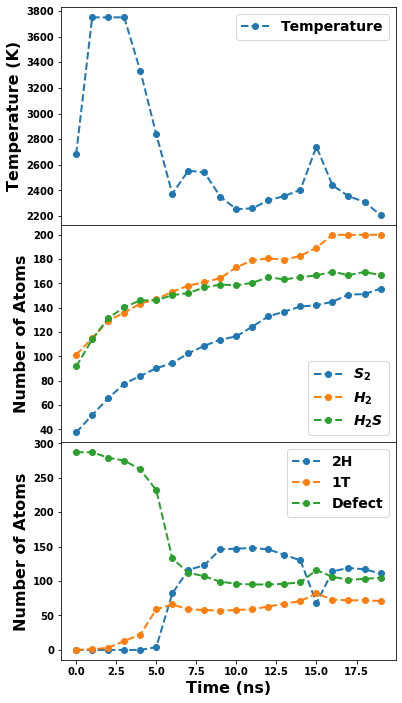

(32, 20, 4) (32, 20, 3)


In [870]:
val=25
#fig, ax = plt.subplots(1,3,figsize=(16,4))
fig, ax = plt.subplots(3,1,figsize=(6,12))
print(Ht_conc[val])
c_legent = ['Temperature','$S_2$','$H_2$','$H_2S$']
x_legend = ['2H','1T','Defect']
ax[0].plot(Cn_[val,:,0],marker='o', linestyle='dashed',linewidth=2, markersize=6)
for i in range(3):
    Y_conc = torch.round(natoms*next_Y_mu[val,:,i])
    ax[1].plot(Cn_[val,:,i+1],marker='o', linestyle='dashed',linewidth=2, markersize=6)
    ax[2].plot(Y_conc,marker='o', linestyle='dashed',linewidth=2, markersize=6)
#plt.xlim([0.0,20.0])
ax[0].set_ylabel('Temperature (K)',weight='bold',fontsize=16)
ax[1].set_ylabel('Number of Atoms',weight='bold',fontsize=16)
ax[2].set_ylabel('Number of Atoms',weight='bold',fontsize=16)
ax[2].set_xlabel('Time (ns)',weight='bold',fontsize=16)
ax[0].legend([c_legent[0]],loc=1,prop={'size': 14})
ax[1].legend(c_legent[1:],loc=4,prop={'size': 14})
ax[2].legend(x_legend,loc=1,prop={'size': 14})
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig("long_time.png",dpi=300)
plt.show()

Y_conc = torch.round(natoms*next_Y_mu).numpy()
print(Cn_.numpy().shape,Y_conc.shape)

In [723]:
Cn_[val,1:,0]-Cn_[val,:-1,0]
#Cn_[val,1:,0]

tensor([1066.7363,    0.0000, -253.2097, -289.8943, -480.7705, -168.0674,
        -255.0803,  -43.5100,   70.4551,   13.5310, -103.4138,   17.1782,
          20.8682,  -70.4888,   88.4673,  189.5635,  -53.3950,   18.9141,
         120.6169])

### Visulaize the moving avegrage of rewards as a function of training episode of RL

In [724]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

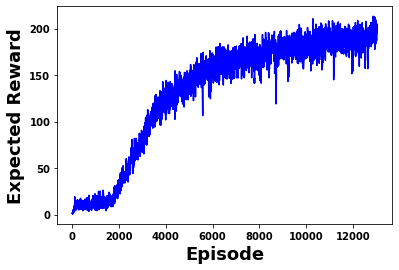

In [725]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
cum_reward = moving_average(reward_trj,5)
plt.plot(cum_reward,c='b')
plt.xlabel('Episode',weight='bold',fontsize=18)
plt.ylabel('Expected Reward',weight='bold',fontsize=18)
#plt.savefig("RL_training.png",dpi=300)
plt.show()

### Generate new trajectory for evalulation using the trained RL Agent on new environment

In [966]:
sim_condition = reaction_condition()
env = environment(md_model,sim_condition)

In [975]:
rl_agent.model.eval()
C_ = np.expand_dims(env.generate_range_T_S(H2_val=20.0,H2S_val=20.0,batch=batch),axis=1)
Cn_ = torch.tensor(C_,dtype=torch.float32)
Y0_ = torch.zeros((Cn_.size()[0],3),dtype=torch.float32)
Y0_[:,2] = 1.0
next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
for j in range(19):
    cur_state = hx[:,j,:]
    with torch.no_grad():
        action,log_prob,mu,state_value = rl_agent.select_action(cur_state)
    cmean = Cn_[:,j,:] + action * action_scale
    #clip condtion within simulation range
    for k in range(cmean.size()[0]):
        if cmean[k,0] < 750.0:
            cmean[k,0] = 750.0
        if cmean[k,0] > 3750.0:
            cmean[k,0] = 3750.0
        if cmean[k,1] < 20.0:
            cmean[k,1] = 20.0
        if cmean[k,1] > 200.0:
            cmean[k,1] = 190.0
        if cmean[k,2] < 20.0:
            cmean[k,2] = 20.0
        if cmean[k,2] > 200.0:
            cmean[k,2] = 190.0
        if cmean[k,3] < 20.0:
            cmean[k,3] = 20.0
        if cmean[k,3] > 200.0:
            cmean[k,3] = 190.0
    Cn_ = torch.cat((Cn_,cmean.unsqueeze(1)),dim=1)
    next_Y_mu,_,hx = env.get_states_representation(Cn_,Y0_)
    Ht_conc = torch.round(natoms*next_Y_mu[:,j,0])
print("done:",Ht_conc)

done: tensor([141., 141.,  70.,  81., 118., 127.,  65., 129., 145., 148., 121.,  19.,
        121., 107., 127., 116., 149., 154., 136., 108.,  16.,  40., 116., 118.,
        146., 157., 131., 112., 112.,  74., 109., 107.])


tensor(109.)


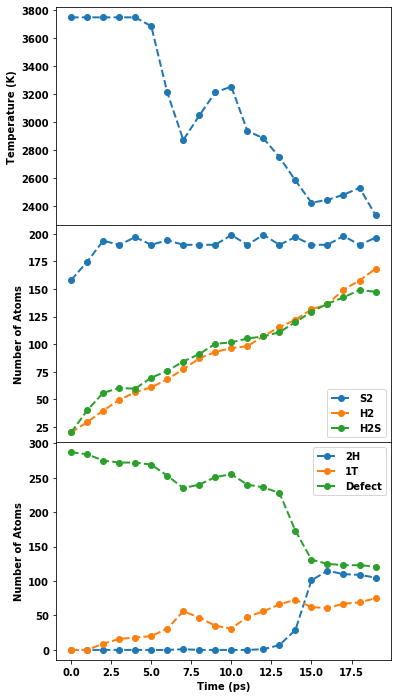

(32, 20, 4) (32, 20, 3)


In [984]:
val=30
#fig, ax = plt.subplots(1,3,figsize=(16,4))
fig, ax = plt.subplots(3,1,figsize=(6,12))
print(Ht_conc[val])
c_legent = ['Temperature','S2','H2','H2S']
x_legend = ['2H','1T','Defect']
ax[0].plot(Cn_[val,:,0],marker='o', linestyle='dashed',linewidth=2, markersize=6)
for i in range(3):
    Y_conc = torch.round(natoms*next_Y_mu[val,:,i])
    ax[1].plot(Cn_[val,:,i+1],marker='o', linestyle='dashed',linewidth=2, markersize=6)
    ax[2].plot(Y_conc,marker='o', linestyle='dashed',linewidth=2, markersize=6)
ax[0].set_ylabel('Temperature (K)',weight='bold')
ax[1].set_ylabel('Number of Atoms',weight='bold')
ax[2].set_ylabel('Number of Atoms',weight='bold')
ax[2].set_xlabel('Time (ps)',weight='bold')
ax[1].legend([c_legent[0]])
ax[1].legend(c_legent[1:])
ax[2].legend(x_legend)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig("long_time.png",dpi=300)
plt.savefig("temp_gas_effect_part3.png",dpi=300)
plt.show()

Y_conc = torch.round(natoms*next_Y_mu).numpy()
print(Cn_.numpy().shape,Y_conc.shape)
np.save("temp_gas_effect_part3_sim_con",Cn_.numpy())
np.save("temp_gas_effect_part3_phase",Y_conc)